# Dynamo on scNT-seq data

The notebook is largely adopted from the authors of scNT-seq paper to repeating the figure:
https://github.com/wulabupenn/scNT-seq/blob/master/notebook_for_figures/neuron_revision_figures_n_s_velocity.ipynb

In [1]:
import dynamo as dyn
import numpy as np
import pandas as pd

print(dyn.__version__)

0.95.2.dev142+9c30240


## Load data

Data set has been pre-combined by replace unspliced with new RNAs. The processing can be found in the above notebook, which should equivalent to the simplied codes in ./scNTseq_data_combine.ipynb

You can also download this file `neuron_splicing_nascent.h5ad` from [here](https://sourceforge.net/projects/brie-rna/files/examples/scNTseq/).

In [2]:
dat_dir = '/storage/yhhuang/research/rnaVelo/scNT/'

In [3]:
adata = dyn.read(dat_dir + "/neuron_splicing_nascent.h5ad") #note, unspliced is replaced by new

In [4]:
adata

AnnData object with n_obs × n_vars = 3066 × 37007
    obs: 'cellname', 'time', 'early', 'late'
    var: 'gene_short_name'
    obsm: 'X_umap'
    layers: 'spliced', 'unspliced'

### Data filtering 

In [5]:
adata.obs['label_time'] = 2 # this is the labeling time 
tkey = 'label_time'
# adata = adata[adata.obs.time.isin(time), :]

cell_filter = (adata.X > 0).sum(1) > 2000

adata = adata[cell_filter.A1, :]

peng_gene_list = pd.read_csv(dat_dir + '/0408_grp_info.txt', sep='\t')

adata = adata[:, peng_gene_list.index]

adata

/home/yuanhua/.conda/envs/dyna/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


View of AnnData object with n_obs × n_vars = 3060 × 97
    obs: 'cellname', 'time', 'early', 'late', 'label_time'
    var: 'gene_short_name'
    obsm: 'X_umap'
    layers: 'spliced', 'unspliced'

## Fitting dynamo

In [6]:
adata = dyn.pp.recipe_monocle(adata, n_top_genes=1000, fc_kwargs={"min_expr_genes_s": 5,
    "min_expr_genes_u": 2,}, fg_kwargs={"shared_count": 5},
#                       keep_filtered_cells=False,
#                       keep_filtered_genes=False,
                      # total_layers='spliced',
                      )

dyn.tl.dynamics(adata, model='stochastic')

dyn.tl.reduceDimension(adata, reduction_method='umap')

dyn.tl.cell_velocities(adata, calc_rnd_vel=True)
adata.obs['time'] = adata.obs.time.astype('category')

Trying to set attribute `.uns` of view, copying.
/home/yuanhua/.conda/envs/dyna/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/yuanhua/.conda/envs/dyna/lib/python3.7/site-packages/dynamo/preprocessing/preprocess.py:1506: UserWarning: only 96 genes passed basic filtering, but you requested 1000 genes for feature selection. Try lowering the gene selection stringency: {'min_expr_cells': 0, 'min_expr_avg': 0, 'max_expr_avg': inf, 'svr_gamma': None, 'winsorize': False, 'winsor_perc': (1, 99.5), 'sort_inverse': False}
  warnings.warn(f'only {pass_basic_filter_num} genes passed basic filtering, but you requested {n_top_genes} '
/home/yuanhua/.conda/envs/dyna/lib/python3.7/site-packages/dynamo/preprocessing/utils.py:439: UserWarning: `total_szfactor` is not `None` and it is not in adata object.
  warnings.warn("`total_szfa

### Plotting the cell transition

/home/yuanhua/.conda/envs/dyna/lib/python3.7/site-packages/dynamo/plot/scatters.py:479: FutureWarning: Categorical.to_dense is deprecated and will be removed in a future version.  Use np.asarray(cat) instead.
  labels = _color.to_dense() if is_categorical_dtype(_color) else _color


<Figure size 600x400 with 0 Axes>

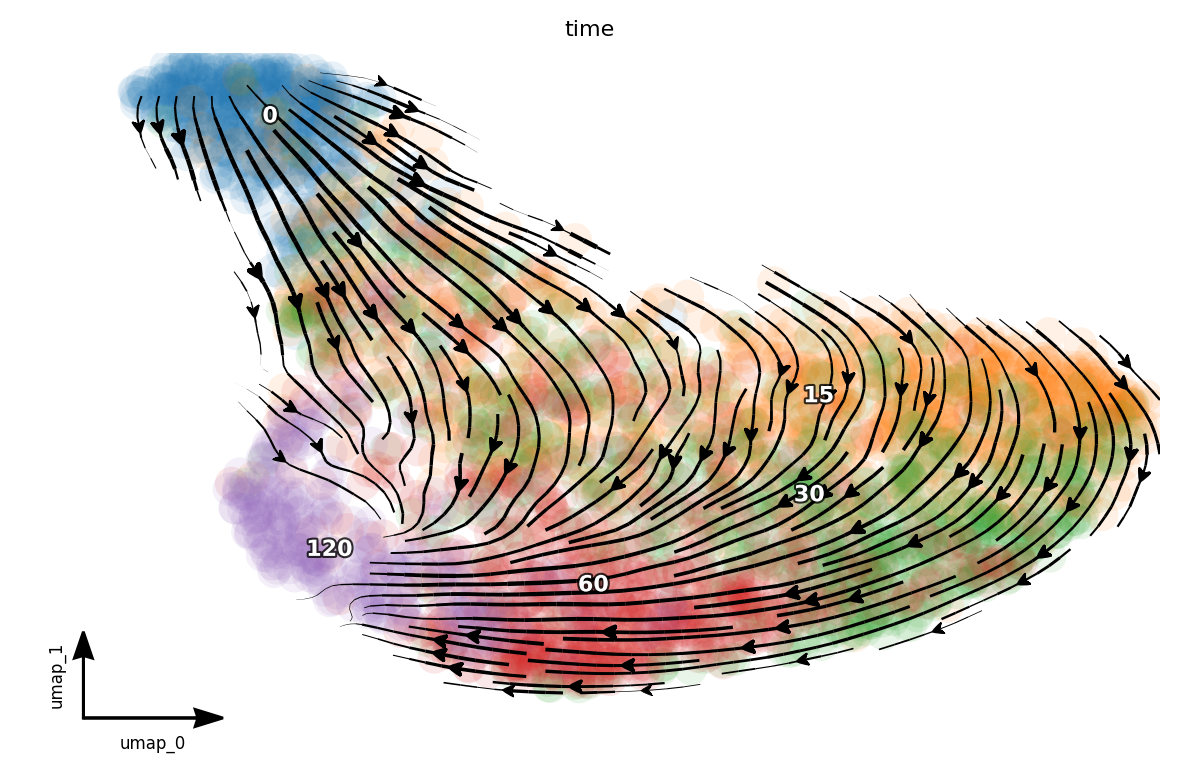

In [7]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
dyn.pl.streamline_plot(adata, color='time', color_key=colors, basis='umap', 
                       ncols=5, pointsize=0.5,
                       show_legend='on data', save_show_or_return='show')  
# ['GRIA3', 'LINC00982', 'AFF2']

In [8]:
adata

AnnData object with n_obs × n_vars = 3060 × 97
    obs: 'cellname', 'time', 'early', 'late', 'label_time', 'nGenes', 'nCounts', 'pMito', 'use_for_pca', 'unspliced_Size_Factor', 'initial_unspliced_cell_size', 'Size_Factor', 'initial_cell_size', 'spliced_Size_Factor', 'initial_spliced_cell_size', 'ntr'
    var: 'gene_short_name', 'nCells', 'nCounts', 'pass_basic_filter', 'use_for_pca', 'ntr', 'beta', 'gamma', 'half_life', 'alpha_b', 'alpha_r2', 'gamma_b', 'gamma_r2', 'gamma_logLL', 'delta_b', 'delta_r2', 'uu0', 'ul0', 'su0', 'sl0', 'U0', 'S0', 'total0', 'use_for_dynamics', 'use_for_transition'
    uns: 'pp', 'PCs', 'explained_variance_ratio_', 'pca_fit', 'feature_selection', 'dynamics', 'neighbors', 'grid_velocity_umap', 'grid_velocity_umap_rnd'
    obsm: 'X_umap', 'X_pca', 'X', 'velocity_umap', 'X_umap_rnd', 'velocity_umap_rnd'
    layers: 'spliced', 'unspliced', 'X_unspliced', 'X_spliced', 'M_u', 'M_uu', 'M_s', 'M_us', 'M_ss', 'velocity_S'
    obsp: 'moments_con', 'connectivities', 'di